# 專題分析-預測離職率

### ◉資料來源：https://www.kaggle.com/ludobenistant/hr-analytics

# 1.資料匯入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.ensemble import VotingClassifier


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文
plt.rcParams['axes.unicode_minus']=False #正常顯示負號



pd.set_option("display.max_columns",25) #設定pandas最多顯示出25個欄位資訊
df = pd.read_csv("HR_comma_sep.csv",encoding = "big5") #15000筆
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
5235,0.91,0.79,5,273,4,1,0,0,support,medium
9081,0.61,0.69,2,164,2,0,0,0,RandD,medium
3497,0.74,0.97,2,135,4,0,0,0,IT,medium
10708,0.56,0.41,5,152,3,0,0,0,sales,medium
5229,0.99,0.99,3,158,2,0,0,0,technical,low


### ▲欄位摘要

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
dept                     14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# 2.資料預處理

In [3]:
df.groupby('salary').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
salary,,,,,,,,
high,0.637470,0.704325,3.767179,199.867421,3.692805,0.155214,0.066289,0.058205
low,0.600753,0.717017,3.799891,200.996583,3.438218,0.142154,0.296884,0.009021
medium,0.621817,0.717322,3.813528,201.338349,3.529010,0.145361,0.204313,0.028079


In [4]:
#df.groupby('satisfaction_level').mean()

In [5]:
df.groupby('dept').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
dept,,,,,,,,
IT,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


## 2-1.LabelEncoding 

In [6]:
df['salary_rank'] = df['salary'].replace({'low':1,'medium':2,'high':3})
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary,salary_rank
2268,0.96,0.67,6,190,3,0,0,0,support,low,1
5737,0.81,0.49,2,205,5,1,0,0,sales,low,1
13678,0.55,0.67,3,150,2,0,0,1,sales,low,1
8261,0.60,0.61,3,195,3,0,0,0,sales,medium,2
10995,0.67,0.49,3,224,3,0,0,0,IT,low,1


In [7]:
df['dept_rank'] = df['dept'].replace({'IT':1,'RandD':2,'accounting':3,'hr':4,'management':5,
                                 'marketing':6,'product_mng':7,'sales':8,'support':9,'technical':10})
df.sample(5)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary,salary_rank,dept_rank
10919,0.54,0.44,3,153,2,0,0,0,technical,low,1,10
10672,0.87,0.97,4,243,3,0,0,0,IT,high,3,1
3040,0.57,0.61,3,243,3,0,0,0,IT,medium,2,1
6137,0.92,0.50,5,258,3,0,0,0,hr,medium,2,4
1503,0.40,0.46,2,155,3,0,1,0,support,medium,2,9


# 3.資料預處理 - 機器學習

## 3-1.切分訓練及測試資料 

In [8]:
from sklearn.model_selection import train_test_split

X = df[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','dept_rank','salary_rank']]
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

## 3-2.標準化 

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)

## 3-3.產生高次方項 

In [10]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2) #0~2次方

X_train_poly = quadratic.fit_transform(X_train_std)
X_test_poly = quadratic.fit_transform(X_test_std) 
X_poly = quadratic.fit_transform(X_std)

## 3-3.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

In [11]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


# 4.使用單一分類演算法進行專題分析

## 4-1.決策樹

In [12]:
#from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini',max_depth=5)#可調整Gini或Entropy，決策樹可不用做資料標準化
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
#from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", feature_names=['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','dept_rank','salary_rank'],
                class_names=['1','0'],)

### 4-1-1.產生決策樹的圖片 

In [14]:
!dot -Tpng tree.dot -o tree.png

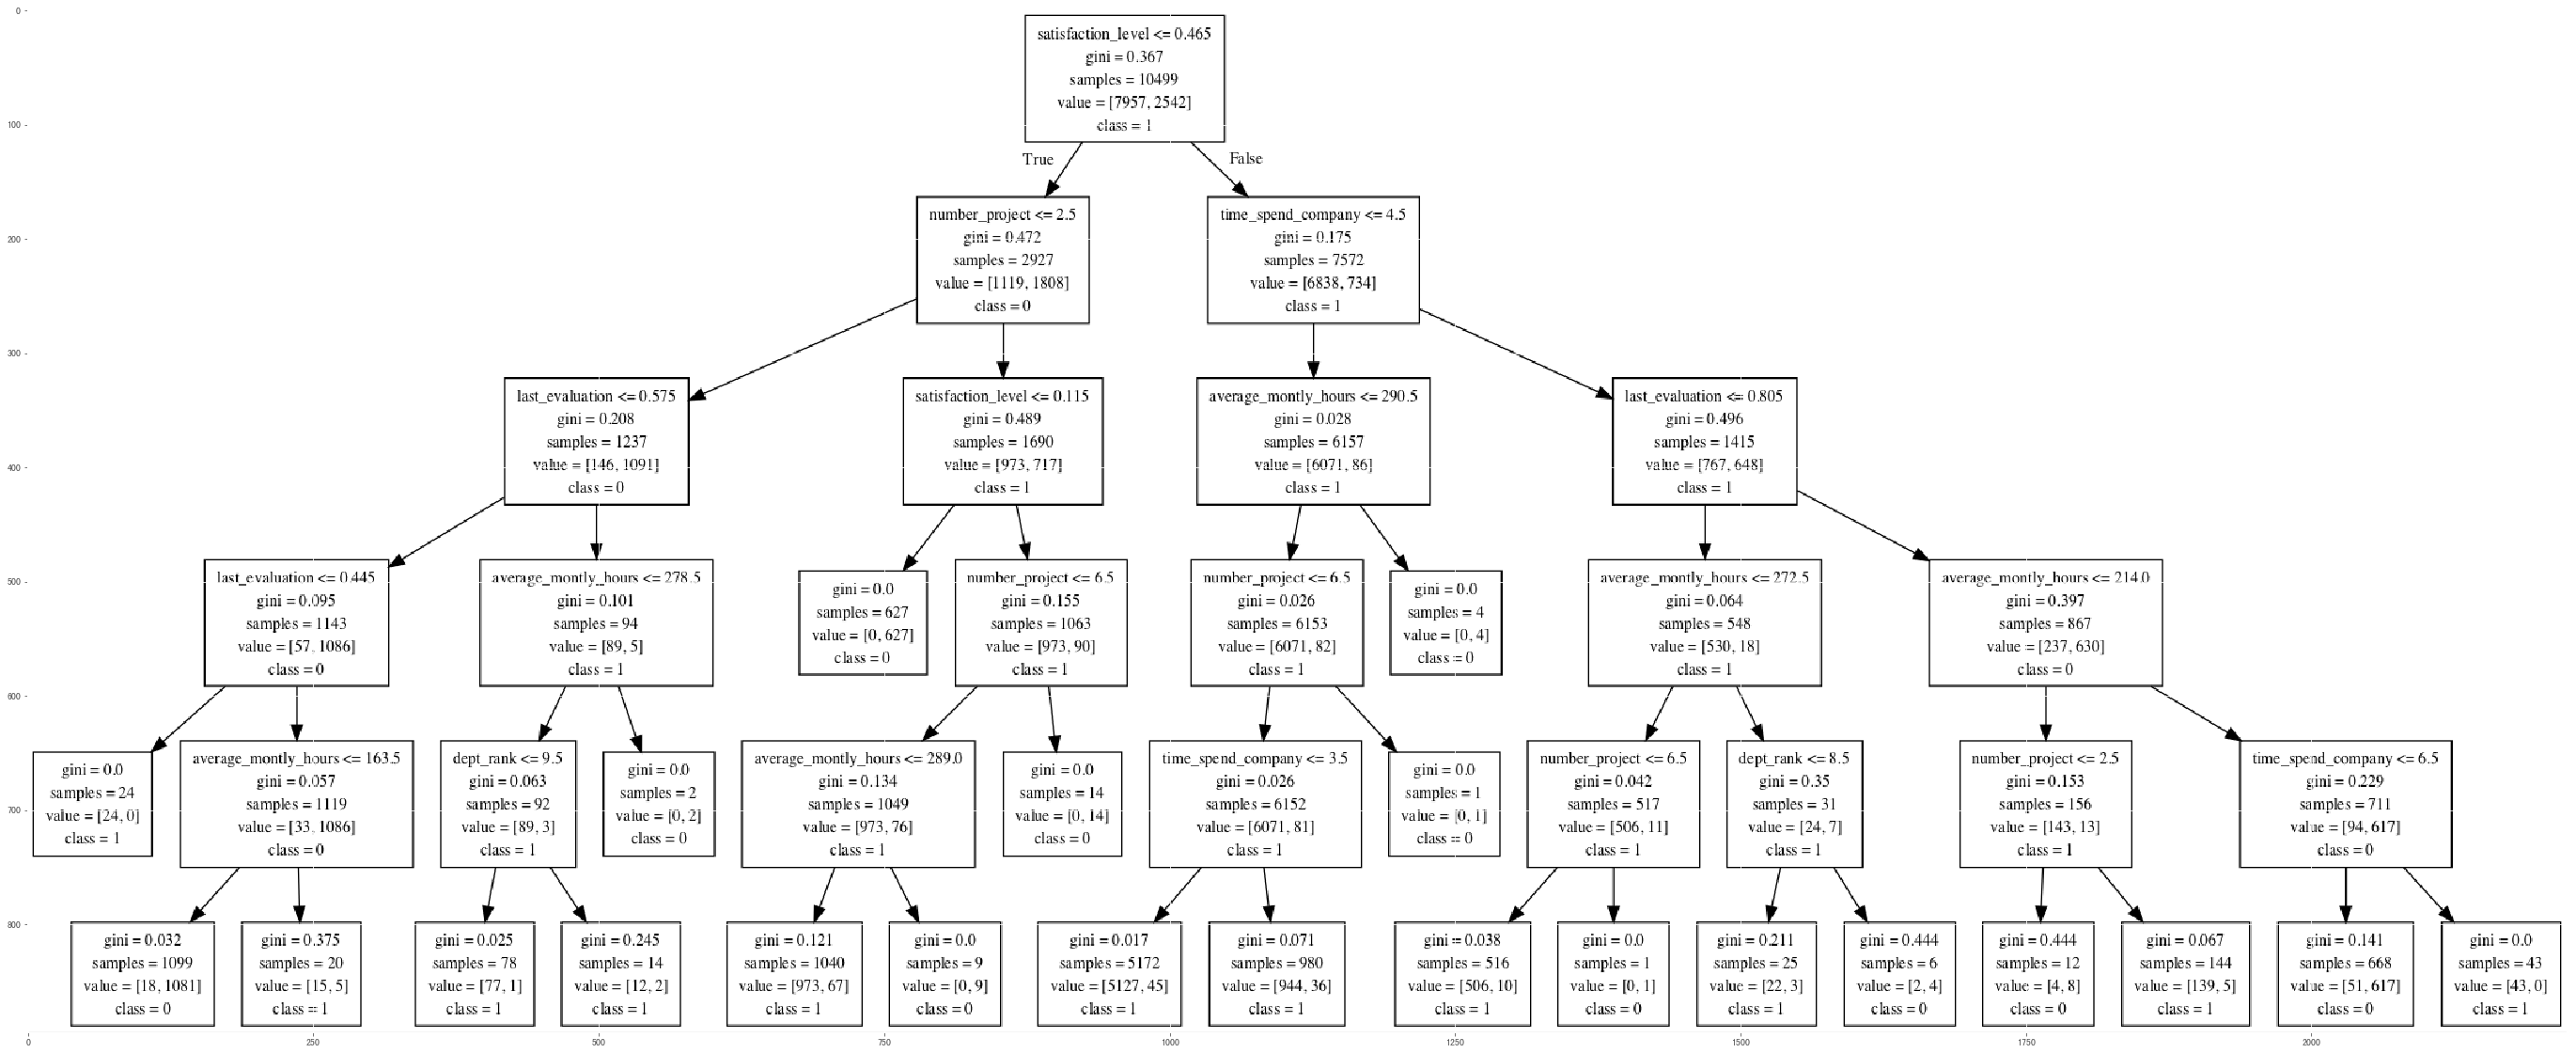

In [15]:
#import matplotlib.image as mpimg
#import matplotlib.pyplot as plt

%matplotlib inline
img = mpimg.imread('tree.png')
fig = plt.figure(figsize=(100,20))
plt.imshow(img)

### 4-1-2.準確度預測

In [16]:
#from sklearn import metrics
print(metrics.classification_report(y_test, tree.predict(X_test)))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      3471
          1       0.95      0.93      0.94      1029

avg / total       0.97      0.97      0.97      4500



### 4-1-3.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

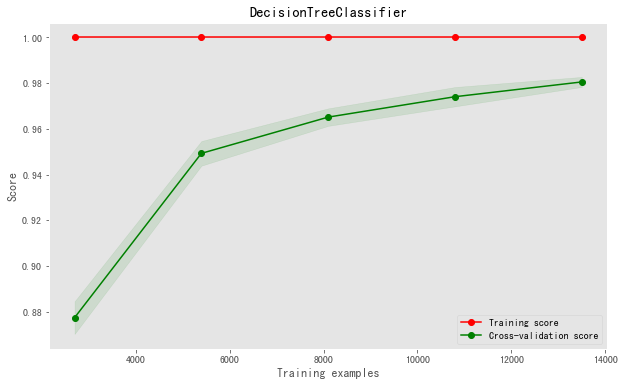

In [17]:
#from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = DecisionTreeClassifier()

plot_learning_curve(estimator, "DecisionTreeClassifier", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 4-2.KNN

In [18]:
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=5, weights='distance') #k, weight (uniform, distance)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

### 4-2-1.準確度 & 混淆矩陣

In [19]:
print(metrics.classification_report(y_test, knn.predict(X_test_std)))
print(metrics.confusion_matrix(y_test, knn.predict(X_test_std),
                               labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      3471
          1       0.91      0.96      0.93      1029

avg / total       0.97      0.97      0.97      4500

[[3367  104]
 [  37  992]]


### 4-2-3.視覺化混淆矩陣函式（from scikit-learn官網） 

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#Source code from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Confusion matrix, without normalization
[[3367  104]
 [  37  992]]


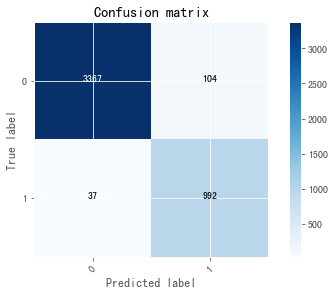

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, knn.predict(X_test_std))
target_names = [0,1]

plot_confusion_matrix(cnf_matrix, classes=target_names) #注意：targeet_names必須和confusion_matrix中labels的順序一致
plt.show()

### 4-2-4.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

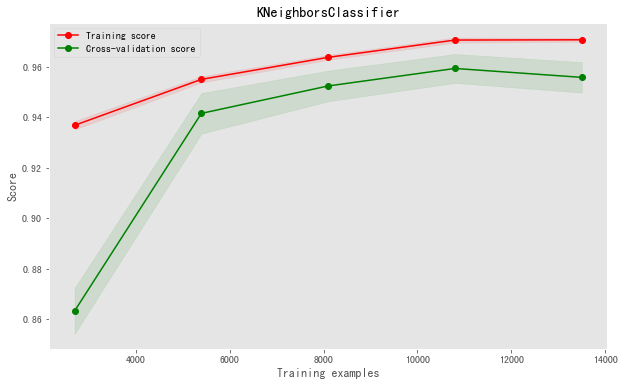

In [22]:
#from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = KNeighborsClassifier()

plot_learning_curve(estimator, "KNeighborsClassifier", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

### 4-2-5.準確度預測

In [23]:
print(metrics.classification_report(y_test, knn.predict(X_test_std)))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      3471
          1       0.91      0.96      0.93      1029

avg / total       0.97      0.97      0.97      4500



## 4-3.SVC

In [24]:
#from sklearn.svm import SVC

svc = SVC(C=2.0, kernel="rbf")
svc.fit(X_train_std, y_train)

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
print(metrics.classification_report(y_test, svc.predict(X_test_std)))
print(metrics.confusion_matrix(y_test, svc.predict(X_test_std),labels=[0,1]))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98      3471
          1       0.94      0.91      0.92      1029

avg / total       0.97      0.97      0.97      4500

[[3411   60]
 [  92  937]]


# 5.使用整體學習的演算法進行專題分析

## 5-1.VotingClassifier

In [26]:
clf1 = DecisionTreeClassifier(max_depth=5)
clf2 = KNeighborsClassifier(n_neighbors=2)
clf3 = SVC(kernel='rbf',probability=True) #probability要設成True(同時計算每個分類的機率)，classification_report才能work

eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),('svc', clf3)], voting='soft', weights=[3, 1, 1])
eclf.fit(X_train_std, y_train)
print(metrics.classification_report(y_test, eclf.predict(X_test_std)))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      3471
          1       0.96      0.93      0.94      1029

avg / total       0.97      0.97      0.97      4500



/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 5-2.Bagging

In [27]:
from sklearn.ensemble import BaggingClassifier

bagc = BaggingClassifier(n_estimators=100, oob_score=True)
bagc.fit(X,y)
print("oob_score(accuary):",bagc.oob_score_)

oob_score(accuary): 0.9909993999599973


In [28]:
from sklearn.ensemble import BaggingClassifier

bagc = BaggingClassifier(n_estimators=100)
bagc.fit(X_train, y_train)
print(metrics.classification_report(y_test, bagc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3471
          1       0.99      0.97      0.97      1029

avg / total       0.99      0.99      0.99      4500



## 5-3.隨機森林(Random Forest)

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='auto', oob_score=True)
rfc.fit(X,y)
print("oob_score(accuary):",rfc.oob_score_)

oob_score(accuary): 0.9927328488565904


In [30]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X,y)
print(metrics.classification_report(y_test, rfc.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3471
          1       1.00      1.00      1.00      1029

avg / total       1.00      1.00      1.00      4500



## 5-4.AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100)
adb.fit(X_train, y_train)
print(metrics.classification_report(y_test, adb.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97      3471
          1       0.92      0.91      0.91      1029

avg / total       0.96      0.96      0.96      4500

